In [ ]:
import zipfile
import os
from pycocotools.coco import COCO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, annotations_file, image_dir, batch_size=32, image_size=(128, 128)):
        self.coco = COCO(annotations_file)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size

        # Print information about the loaded COCO dataset
        print("COCO dataset info:")
        print(" - Number of images:", len(self.coco.imgs))
        print(" - Number of annotations:", len(self.coco.anns))
        print(" - Categories:", len(self.coco.cats))
        print("Available Category IDs:", self.coco.cats.keys())

        # Assuming you have three categories with IDs 1, 2, and 3
        self.category_ids = [1, 2, 3]  # Change this to your specific category IDs
        self.image_ids = self.coco.getImgIds(catIds=self.category_ids)

        # Print information about the dataset
        print("Custom dataset info:")
        print(" - Number of images:", len(self.image_ids))
        print(" - Category IDs:", self.category_ids)

    # Rest of the class remains the same

# Specify the uploaded zip file name
zip_file_name = "BrainTumorMRIs.zip"

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract to /content directory

# Specify the paths for the annotation file and the image directory
annotations_path = "/content/Axial-1.json"
image_dir = "/content/BrainTumorMRIs"  # Corrected path

# Create an instance of the custom dataset
custom_dataset = CustomDataset(annotations_path, image_dir)

# Get the number of unique classes in the training dataset
class_number = len(custom_dataset.category_ids)
print("Number of Unique Classes: {}".format(class_number))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO dataset info:
 - Number of images: 29
 - Number of annotations: 29
 - Categories: 3
Available Category IDs: dict_keys([1, 2, 3])
Custom dataset info:
 - Number of images: 0
 - Category IDs: [1, 2, 3]
Number of Unique Classes: 3


In [ ]:
from collections import defaultdict
import json
import numpy as np

class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        #self.licenses_dict = {}

        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        #for license in coco['licenses']:
        #    self.licenses_dict[license['id']] = license

    def get_imgIds(self):
        return list(self.im_dict.keys())

    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]

    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]

    #def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [ ]:
coco_annotations_file="/content/Axial-1.json"
coco_images_dir="/content/BrainTumorMRIs"
coco= COCOParser(coco_annotations_file, coco_images_dir)

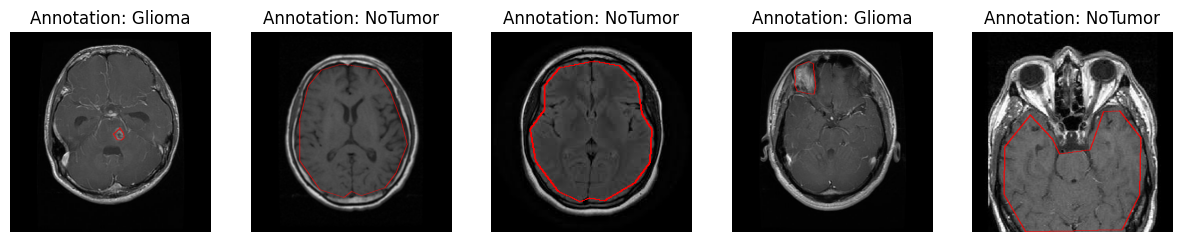

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Get a random subset of image IDs
random_image_ids = random.sample(coco.get_imgIds(), k=5)  # Change '5' to the number of random images you want to display

# Set up a subplot grid
fig, axs = plt.subplots(1, len(random_image_ids), figsize=(15, 5))

# Iterate through the random image IDs and display images with annotations
for i, image_id in enumerate(random_image_ids):
    # Get annotations for the current image
    ann_ids = coco.get_annIds(image_id)
    annotations = coco.load_anns(ann_ids)

    # Get image information
    img_info = coco.im_dict[image_id]

    # Load the image
    img_path = os.path.join(coco_images_dir, img_info['file_name'])
    img = Image.open(img_path)

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Draw polygon and display category for each annotation
    for annotation in annotations:
        segmentation = annotation['segmentation']
        category_id = annotation['category_id']

        # Flatten the list of vertices
        flattened_vertices = [coord for sublist in segmentation for coord in sublist]

        # Draw the polygon
        draw.polygon(flattened_vertices, outline='red', width=2)

    # Display the category on top of the image
    #draw.text((10, 10), coco.cat_dict[category_id]['name'], fill='red', font=None)

    # Display the image
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Annotation: {}".format(coco.cat_dict[category_id]['name']))

plt.show()


*Code from first cell above, splitting into testing, validation and training sets*

In [ ]:
import zipfile
import os
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, annotations_file, image_dir, batch_size=32, image_size=(128, 128), samples_per_category=5):
        self.coco = COCO(annotations_file)
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.samples_per_category = samples_per_category

        # Assuming you have three categories with IDs 1, 2, and 3
        self.category_ids = [1, 2, 3]  # Change this to your specific category IDs

        # Filter categories with fewer samples than required
        self.category_ids = [cat_id for cat_id in self.category_ids if len(self.coco.getImgIds(catIds=[cat_id])) >= samples_per_category]

        # Split the data into training, validation, and testing sets
        self.train_image_ids, self.val_image_ids, self.test_image_ids = self.split_data()

        # Print information about the dataset
        print("Custom dataset info:")
        print(" - Number of images (Training):", len(self.train_image_ids))
        print(" - Number of images (Validation):", len(self.val_image_ids))
        print(" - Number of images (Testing):", len(self.test_image_ids))
        print(" - Category IDs:", self.category_ids)

    # Rest of the class remains the same

    def split_data(self):
        train_image_ids, val_test_image_ids = [], []

        for cat_id in self.category_ids:
            cat_image_ids = self.coco.getImgIds(catIds=[cat_id])
            cat_train_ids, cat_val_test_ids = train_test_split(cat_image_ids, test_size=0.4, random_state=42)
            cat_val_ids, cat_test_ids = train_test_split(cat_val_test_ids, test_size=0.5, random_state=42)

            train_image_ids.extend(cat_train_ids[:self.samples_per_category])
            val_test_image_ids.extend(cat_val_test_ids[:self.samples_per_category])

        val_image_ids, test_image_ids = train_test_split(val_test_image_ids, test_size=0.5, random_state=42)

        return train_image_ids, val_image_ids, test_image_ids

# Specify the uploaded zip file name
zip_file_name = "BrainTumorMRIs.zip"

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/")  # Extract to /content directory

# Specify the paths for the annotation file and the image directory
annotations_path = "/content/Axial-1.json"
image_dir = "/content/BrainTumorMRIs"  # Corrected path

# Create an instance of the custom dataset with 5 samples per category
custom_dataset = CustomDataset(annotations_path, image_dir, samples_per_category=5)

# Get the number of unique classes in the training dataset
class_number = len(custom_dataset.category_ids)
print("Number of Unique Classes: {}".format(class_number))


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Custom dataset info:
 - Number of images (Training): 15
 - Number of images (Validation): 6
 - Number of images (Testing): 6
 - Category IDs: [1, 2, 3]
Number of Unique Classes: 3


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 32.10 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [ ]:
!pip install keras==2.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.2.4 which is incompatible.


In [ ]:
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize

In [ ]:
from mrcnn.config import Config

class CustomConfig(Config):
    NAME = "custom_config"  # A unique name for your configuration
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3  # Number of classes (including background)

# Create an instance of the custom configuration
config = CustomConfig()


In [ ]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [ ]:
MODEL_DIR = "/content/mask_rcnn_model"


In [ ]:
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

NameError: name 'mrcnn' is not defined